In [1]:
import json
import numpy as np
import csv

questions = []

with open("data/questions.tsv", 'r', encoding="utf-8") as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t')

    for row in tsvin:
        columns = []
        columns.append(row[1])
        columns.append(row[2])
        columns.append(row[3])
        
        questions.append(columns)

In [2]:
import re

sub_questions = []    
for t in questions:
    result = re.compile('-+').sub('', t)
    result = re.compile('[0-9]+').sub('0', result)
    result = re.compile('\s+').sub('', result)
    # ... and many regular expression substitutions

    columns = []
    columns.append(result)
    columns.append(t[1])
    columns.append(t[2])

    # remove empty string question
    if len(a) > 0:
        sub_questions.append(columns)

# remove header
sub_questions.pop(0)

['question', 'answer', 'category']

# Create samples and labels

Cap the samples' size it's 700 samples because the payment label has only 688 samples. Define the labels 'Account' as 2, 'Payment' as 3, and the other all labels as 1.

In [5]:
labels = []
texts = []
threashold = 700
cnt1 = 0
cnt2 = 0
cnt3 = 0

for i, row in enumerate(sub_questions):
    if 'Account' in row[2]:
        if cnt2 < threashold:
            cnt2 += 1
            labels.append(2)
            texts.append(row[0])
    elif 'Payment' in row[2]:
        if cnt3 < threashold:
            cnt3 += 1
            labels.append(3)
            texts.append(row[0])
    else:
        if cnt1 < threashold:
            cnt1 += 1
            texts.append(row[0])
            labels.append(1)

The labels 1 and 2 have 700 samples, and the 3 has 688 samples.

In [6]:
a = np.asarray(labels)
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{1: 700, 2: 700, 3: 688}

In [7]:
import MeCab
import re

def tokenize(text):
    wakati = MeCab.Tagger("-O wakati")
    wakati.parse("")
    words = wakati.parse(text)
    
    if words[-1] == u"\n":
        words = words[:-1]
        
    return words

texts = [tokenize(a) for a in texts]

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np

maxlen = 1000
training_samples = 1600
validation_samples = len(texts) - training_samples
max_words = 15000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(to_categorical(labels))

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
print(len(labels))
print(len(indices))
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 6831 unique tokens.
Shape of data tensor:(2088, 1000)
Shape of label tensor:(2088, 4)
2088
2088


In [16]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import LSTM
import tensorflow as tf

with tf.device('/cpu:0'): # because CPU is faster than GPU
    model = Sequential()
    model.add(Embedding(15000, 100, input_length=maxlen))
    model.add(LSTM(32))
    model.add(Dense(4, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()

    history = model.fit(x_train, y_train, epochs=18, batch_size=100, validation_split=0.2, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         1500000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 1,517,156
Trainable params: 1,517,156
Non-trainable params: 0
_________________________________________________________________
Train on 1600 samples, validate on 488 samples
Epoch 1/18
1600/1600 [==============================] - 10s 7ms/step - loss: 1.3565 - acc: 0.3175 - val_loss: 1.3001 - val_acc: 0.3689
Epoch 2/18
1600/1600 [==============================] - 10s 6ms/step - loss: 1.2254 - acc: 0.3262 - val_loss: 1.1445 - val_acc: 0.3668
Epoch 3/18
1600/1600 [==============================] - 10s 6ms/step - loss: 1.

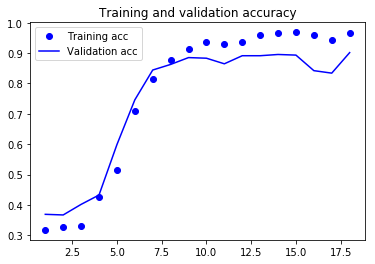

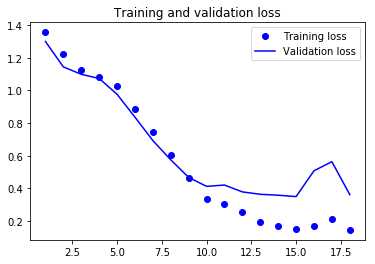

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.save('pre_trained_model.h5')